In [1]:
import pandas as pd
from io import StringIO
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [2]:
df = pd.read_csv('Housing Pricing.csv')
df.head

<bound method NDFrame.head of         Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0        1          60       RL  ...        WD         Normal    208500
1        2          20       RL  ...        WD         Normal    181500
2        3          60       RL  ...        WD         Normal    223500
3        4          70       RL  ...        WD        Abnorml    140000
4        5          60       RL  ...        WD         Normal    250000
...    ...         ...      ...  ...       ...            ...       ...
1455  1456          60       RL  ...        WD         Normal    175000
1456  1457          20       RL  ...        WD         Normal    210000
1457  1458          70       RL  ...        WD         Normal    266500
1458  1459          20       RL  ...        WD         Normal    142125
1459  1460          20       RL  ...        WD         Normal    147500

[1460 rows x 77 columns]>

## Data cleaning

In [3]:
df.drop('Id',inplace=True,axis=1)

In [4]:
missing_cols = df.columns[df.isna().any()]
print('WITH NA : {} '.format(len(missing_cols)))

for col in missing_cols:
  if df[col].dtype == float or df[col].dtype == int:
    _max = df[col].max()
    _min = df[col].min()
    df[col].fillna(method='ffill', inplace=True)
  else:
    df[col].fillna(df[col].mode()[0], inplace=True)

print('WITH NA AFTER : {} '.format(len(df.columns[df.isna().any()])))


WITH NA : 15 
WITH NA AFTER : 0 


From the summary above, the LotFrontage column has 259 missing values, this should be filled in with random values that range from the max value and min value in the column.

## Encoding

In [5]:
categorical_cols = [
'MSSubClass', 'MSZoning','Street','LandContour','LotConfig', 'Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','GarageType','SaleType','SaleCondition'
]

ordinal = [
'LotShape' ,'Utilities' ,'LandSlope' ,'OverallQual' ,'OverallCond' ,'ExterQual' ,'ExterCond' ,'BsmtQual' ,'BsmtCond' ,'BsmtExposure' ,'BsmtFinType1' ,'BsmtFinType2' ,'HeatingQC' ,'Electrical' ,'KitchenQual' ,'Functional' ,'FireplaceQu' ,'GarageFinish' ,'GarageQual' ,'GarageCond' ,'PavedDrive'
]

In [6]:
df[ordinal].sample()

,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive
1120,Reg,AllPub,Mod,6,5,TA,TA,TA,TA,No,Unf,Unf,TA,FuseA,TA,Typ,Gd,Unf,TA,TA,Y


In [7]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
for label in ordinal:
  enc.fit(df[[label]])
  df[[label]] = enc.transform(df[[label]])

df[ordinal].sample()

,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive
954,0.0,0.0,0.0,5.0,4.0,3.0,4.0,2.0,1.0,1.0,2.0,5.0,4.0,4.0,3.0,6.0,2.0,2.0,4.0,4.0,2.0


In [8]:
df[categorical_cols].sample()

,MSSubClass,MSZoning,Street,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,SaleType,SaleCondition
486,20,RL,Pave,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,CBlock,GasA,Y,Attchd,WD,Normal


In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
for label in categorical_cols:
  df = pd.get_dummies(df, columns = [label], drop_first=True)



In [10]:

df.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,...,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,3.0,0.0,0.0,6.0,4.0,2003,2003,196.0,2.0,4.0,2.0,3.0,3.0,2.0,706,5.0,0,150,856,0.0,4.0,856,854,0,1710,1,0,2,1,3,1,2.0,8,6.0,0,2.0,2003.0,1.0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,3.0,0.0,0.0,5.0,7.0,1976,1976,0.0,3.0,4.0,2.0,3.0,1.0,0.0,978,5.0,0,284,1262,0.0,4.0,1262,0,0,1262,0,1,2,0,3,1,3.0,6,6.0,1,4.0,1976.0,1.0,...,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,0.0,0.0,0.0,6.0,4.0,2001,2002,162.0,2.0,4.0,2.0,3.0,2.0,2.0,486,5.0,0,434,920,0.0,4.0,920,866,0,1786,1,0,2,1,3,1,2.0,6,6.0,1,4.0,2001.0,1.0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,0.0,0.0,0.0,6.0,4.0,1915,1970,0.0,3.0,4.0,3.0,1.0,3.0,0.0,216,5.0,0,540,756,2.0,4.0,961,756,0,1717,1,0,1,0,3,1,2.0,7,6.0,1,2.0,1998.0,2.0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,0.0,0.0,0.0,7.0,4.0,2000,2000,350.0,2.0,4.0,2.0,3.0,0.0,2.0,655,5.0,0,490,1145,0.0,4.0,1145,1053,0,2198,1,0,2,1,4,1,2.0,9,6.0,1,4.0,2000.0,1.0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [11]:
X,y = df.drop(["SalePrice"],axis=1), df["SalePrice"]
X_df = df.drop(["SalePrice"],axis=1)

## Standardization

In [12]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(df["SalePrice"].to_numpy().reshape(-1, 1))

y

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ...,
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

## Feature selection

In [13]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [14]:
regressor = LassoCV()
regressor.fit(X,y.ravel())

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [15]:
from sklearn.preprocessing import PowerTransformer
new_x = PowerTransformer().fit_transform(df)

test_data = pd.DataFrame(new_x,columns=df.columns)
test_data = pd.concat([test_data[ordinal]],axis=1)
test_data

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive
0,0.752862,-0.02618,-0.237571,0.665774,-0.479737,-1.148859,0.372617,-0.603720,0.288245,0.666637,-0.361885,0.357663,-0.956770,0.305960,-0.708836,0.271156,-0.370467,-0.365576,0.221022,0.194085,0.299252
1,0.752862,-0.02618,-0.237571,-0.044296,2.025054,0.768841,0.372617,-0.603720,0.288245,-1.441035,-1.617102,0.357663,-0.956770,0.305960,0.931869,0.271156,1.681574,-0.365576,0.221022,0.194085,0.299252
2,-1.371959,-0.02618,-0.237571,0.665774,-0.479737,-1.148859,0.372617,-0.603720,0.288245,-0.678715,-0.361885,0.357663,-0.956770,0.305960,-0.708836,0.271156,1.681574,-0.365576,0.221022,0.194085,0.299252
3,-1.371959,-0.02618,-0.237571,0.665774,-0.479737,0.768841,0.372617,0.979145,-3.470486,0.666637,-1.617102,0.357663,0.692110,0.305960,-0.708836,0.271156,-0.370467,0.974770,0.221022,0.194085,0.299252
4,-1.371959,-0.02618,-0.237571,1.352041,-0.479737,-1.148859,0.372617,-0.603720,0.288245,-1.765453,-0.361885,0.357663,-0.956770,0.305960,-0.708836,0.271156,1.681574,-0.365576,0.221022,0.194085,0.299252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.752862,-0.02618,-0.237571,-0.044296,-0.479737,0.768841,0.372617,-0.603720,0.288245,0.666637,1.163808,0.357663,-0.956770,0.305960,0.931869,0.271156,1.681574,-0.365576,0.221022,0.194085,0.299252
1456,0.752862,-0.02618,-0.237571,-0.044296,0.434524,0.768841,0.372617,-0.603720,0.288245,0.666637,-1.617102,-2.561721,1.245423,0.305960,0.931869,-3.692319,1.681574,0.974770,0.221022,0.194085,0.299252
1457,0.752862,-0.02618,-0.237571,0.665774,2.732905,-2.100234,-2.683996,0.979145,-3.470486,0.666637,-0.361885,0.357663,-0.956770,0.305960,-0.708836,0.271156,-0.370467,-0.365576,0.221022,0.194085,0.299252
1458,0.752862,-0.02618,-0.237571,-0.783220,0.434524,0.768841,0.372617,0.979145,0.288245,-0.678715,-0.361885,-2.561721,0.692110,-3.274017,-0.708836,0.271156,-0.370467,0.974770,0.221022,0.194085,0.299252


L1 selected only  87  features out of  203  from the transformed dataset 


Text(0.5, 1.0, 'Feature Selection Using L1 Embedder')

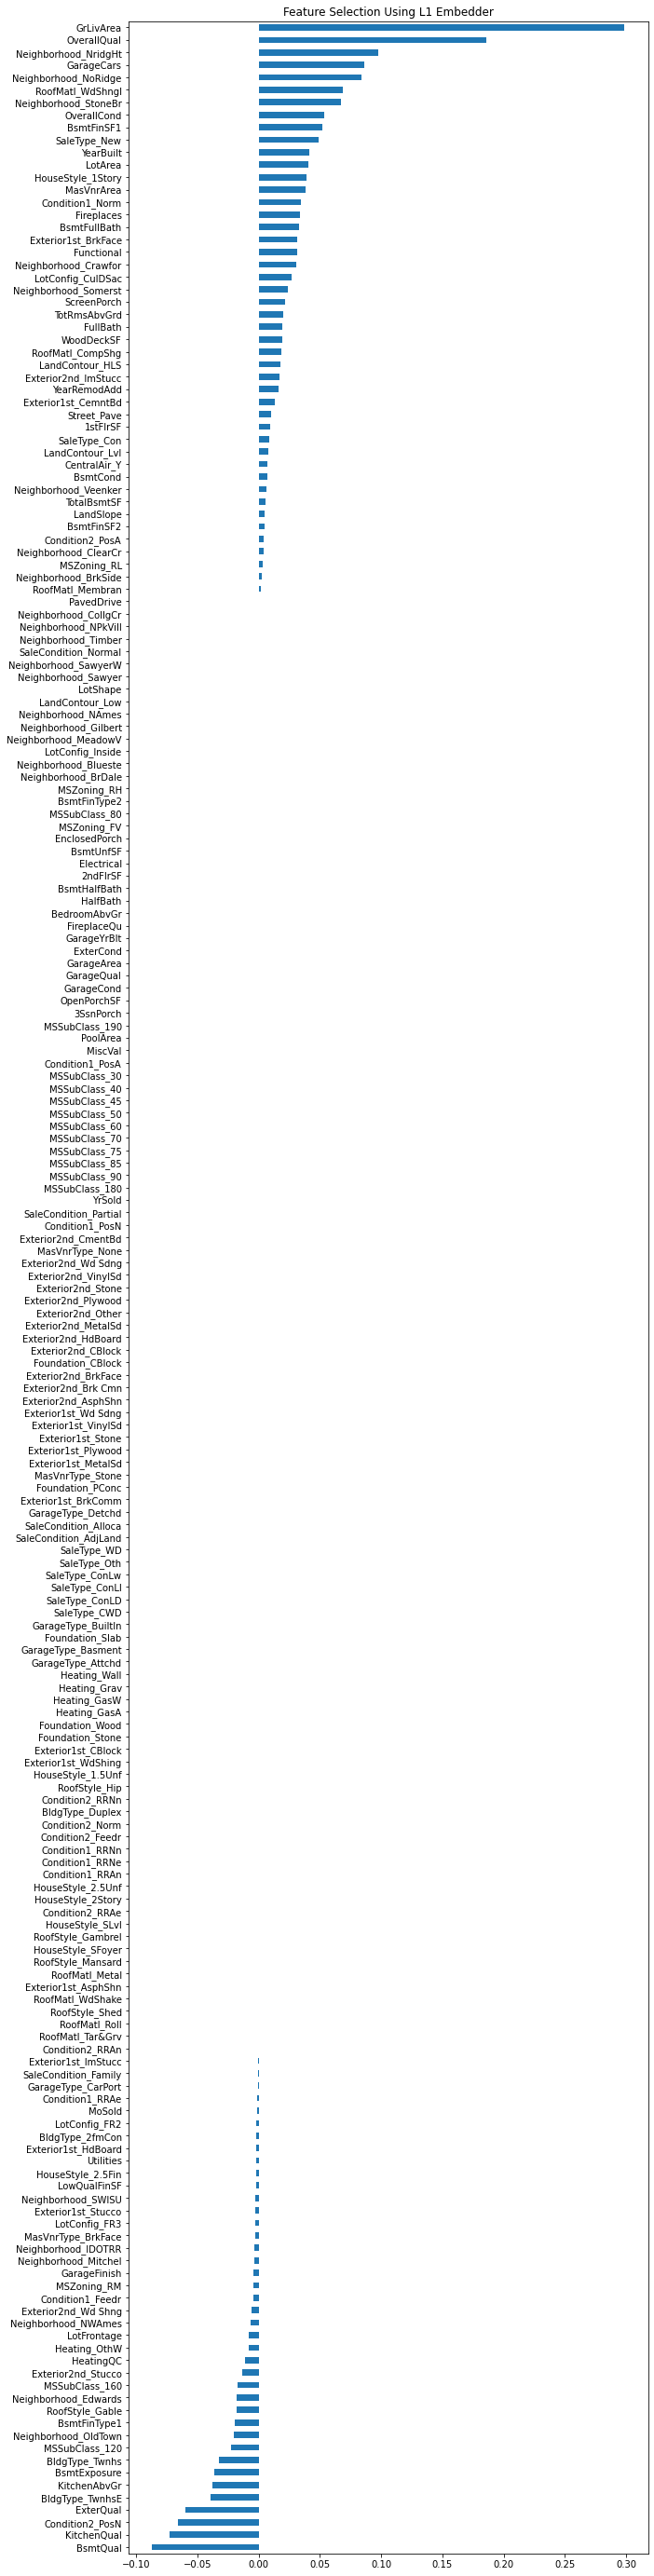

In [16]:
#print(regressor.coef_)
coef_col = pd.Series(regressor.coef_,index=df.drop('SalePrice', axis=1).columns)

#print(coef_col)
sorted_coef = coef_col.sort_values()
matplotlib.rcParams['figure.figsize']=(10.0,50.0)
sorted_coef.plot(kind="barh")

no_of_selected_features = sum(coef_col != 0)
no_of_rejected_features = sum(coef_col == 0)
total_features = no_of_selected_features + no_of_rejected_features
print("L1 selected only ",no_of_selected_features," features out of ",total_features," from the transformed dataset ")
plt.title("Feature Selection Using L1 Embedder")

In [17]:

selected =[]
for label, value in zip(coef_col.index, coef_col.values):
  if value != 0:
    selected.append(label)
selected

['LotFrontage',
 'LotArea',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageFinish',
 'GarageCars',
 'PavedDrive',
 'WoodDeckSF',
 'ScreenPorch',
 'MoSold',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'LandContour_HLS',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_IDOTRR',
 'Neighborhood_Mitchel',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Somerst',
 'Neighbo

In [18]:
X = df.drop(df.columns.difference(selected), axis=1)
new_X = StandardScaler().fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [28]:
epochs =50
model=Sequential()

model.add(Dense(128, input_shape = (X.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.compile(Adam(), loss='mean_squared_error', metrics=['MSE'])

history = model.fit(new_X, y, verbose=0, epochs=epochs)

In [29]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 31596.6660 - MSE: 31596.6660 - val_loss: 0.7461 - val_MSE: 0.7461
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 1.1088 - MSE: 1.1088 - val_loss: 0.7461 - val_MSE: 0.7461
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 1.1088 - MSE: 1.1088 - val_loss: 0.7461 - val_MSE: 0.7461
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 1.1088 - MSE: 1.1088 - val_loss: 0.7461 - val_MSE: 0.7461
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 1.1088 - MSE: 1.1088 - val_loss: 0.7461 - val_MSE: 0.7461
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 1.1088 - MSE: 1.1088 - val_loss: 0.7461 - val_MSE: 0.7461
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 1.1088 - MSE: 1.1088 - val_loss: 0.7461 - val_MSE: 0.7461
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 1.1088 - 

In [30]:
prediction = model.predict(X_test)
prediction

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)